Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking, CmdStan
gr(size=(500,500));

┌ Info: Precompiling CmdStan [593b3428-ca2f-500c-ae53-031589ec8ddd]
└ @ Base loading.jl:1242
┌ Warning: Module Reexport with build ID 989286825986922 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping precompilation since __precompile__(false). Importing CmdStan [593b3428-ca2f-500c-ae53-031589ec8ddd].
└ @ Base loading.jl:1017


CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "02")
cd(ProjDir)

Define the Stan language model

In [3]:
binomialstanmodel = "
// Inferring a Rate
data {
  int N;
  int<lower=0> k[N];
  int<lower=1> n[N];
}
parameters {
  real<lower=0,upper=1> theta;
  real<lower=0,upper=1> thetaprior;
}
model {
  // Prior Distribution for Rate Theta
  theta ~ beta(1, 1);
  thetaprior ~ beta(1, 1);

  // Observed Counts
  k ~ binomial(n, theta);
}
";

Define the Stanmodel and set the output format to :mcmcchains.

In [4]:
stanmodel = Stanmodel(name="binomial", monitors = ["theta"], model=binomialstanmodel,
  output_format=:mcmcchains);
# Use 16 observations
N2 = 15
d = Binomial(9, 0.66)
n2 = Int.(9 * ones(Int, N2));


File /var/folders/fb/m164mwfn3v1btnrpmmyzpvqh0000gn/T/jl_KF8x1X/binomial.stan will be updated.



Show first 5 (generated) observations

In [5]:
k2 = rand(d, N2);
k2[1:min(5, N2)]

5-element Array{Int64,1}:
 7
 5
 6
 6
 8

Input data for cmdstan

In [6]:
binomialdata = Dict("N" => length(n2), "n" => n2, "k" => k2);

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, binomialdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)


Inference for Stan model: binomial_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.031, 0.033, 0.031, 0.032) seconds, 0.13 seconds total
Sampling took (0.053, 0.043, 0.053, 0.039) seconds, 0.19 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -89  2.9e-02     1.1    -91   -89   -88  1.5e+03  7.9e+03  1.0e+00
accept_stat__   0.91  1.7e-03    0.12   0.65  0.96   1.0  4.7e+03  2.5e+04  1.0e+00
stepsize__      0.81  2.3e-02   0.033   0.79  0.79  0.87  2.0e+00  1.1e+01  2.2e+13
treedepth__      2.0  4.8e-02    0.72    1.0   2.0   3.0  2.3e+02  1.2e+03  1.0e+00
n_leapfrog__     5.1  3.4e-01     7.6    1.0   3.0    15  5.1e+02  2.7e+03  1.0e+00
divergent__     0.00      nan    0.00   0.00  0.00  0.00      nan      nan      nan
energy__          90  3.8e-02     1.5     88    90    93  1.5e+03  8.2e+03  1.0e+00
theta           0.67  6.8e-04   0.040  

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean     │ std       │ naive_se    │ mcse        │
│     │ Symbol     │ Float64  │ Float64   │ Float64     │ Float64     │
├─────┼────────────┼──────────┼───────────┼─────────────┼─────────────┤
│ 1   │ theta      │ 0.670771 │ 0.0403619 │ 0.000638178 │ 0.000559745 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%   │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64 │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼─────────┼──────────┼──────────┼──────────┤
│ 1   │ theta      │ 0.590159 │ 0.64428 │ 0.671601 │ 0.698469 │ 0.746855 │


Allocate array of Normal fits

In [8]:
fits = Vector{Normal{Float64}}(undef, 4)
for i in 1:4
  fits[i] = fit_mle(Normal, convert.(Float64, chn.value[:, 1, i]))
  println(fits[i])
end

Normal{Float64}(μ=0.670417306999999, σ=0.03953029342421773)
Normal{Float64}(μ=0.6703661669999991, σ=0.03928429311143465)
Normal{Float64}(μ=0.6711764109999987, σ=0.03948540600852518)
Normal{Float64}(μ=0.6711258949999993, σ=0.04300144705065137)


Plot the 4 chains

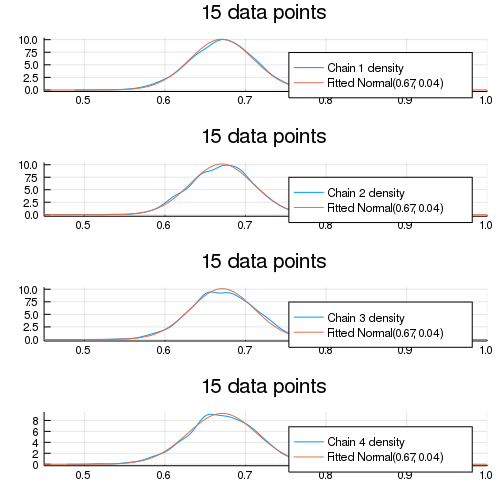

In [9]:
mu_avg = sum([fits[i].μ for i in 1:4]) / 4.0;
sigma_avg = sum([fits[i].σ for i in 1:4]) / 4.0;

if rc == 0
  p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
  x = 0:0.001:1
  for i in 1:4
    vals = convert.(Float64, chn.value[:, 1, i])
    μ = round(fits[i].μ, digits=2)
    σ = round(fits[i].σ, digits=2)
    p[i] = density(vals, lab="Chain $i density",
       xlim=(0.45, 1.0), title="$(N2) data points")
    plot!(p[i], x, pdf.(Normal(fits[i].μ, fits[i].σ), x), lab="Fitted Normal($μ, $σ)")
  end
  plot(p..., layout=(4, 1))
end

Show the hpd region

In [10]:
hpd(chn, alpha=0.055)

HPD

│ Row │ parameters │ upper    │ lower    │
│     │ Symbol     │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┤
│ 1   │ theta      │ 0.594336 │ 0.748021 │

Compute the hpd bounds for plotting

In [11]:
d, p, c = size(chn);
theta = convert(Vector{Float64}, reshape(chn.value, (d*p*c)));
bnds = quantile(theta, [0.045, 0.945])

2-element Array{Float64,1}:
 0.601370235
 0.73344698 

Show hpd region

In [12]:
println("hpd bounds = $bnds\n")

hpd bounds = [0.601370235, 0.73344698]



quadratic approximation

Compute MAP, compare with CmndStan & MLE

In [13]:
tmp = convert(Array{Float64,3}, chn.value)
draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)

4000-element Array{Float64,1}:
 0.705536
 0.651996
 0.691092
 0.678348
 0.741121
 0.592356
 0.761082
 0.617644
 0.654763
 0.683269
 ⋮       
 0.627841
 0.623133
 0.65047 
 0.668513
 0.663586
 0.673506
 0.677687
 0.724515
 0.750444

Compute MAP

In [14]:
using Optim

x0 = [0.5]
lower = [0.2]
upper = [1.0]

inner_optimizer = GradientDescent()

function loglik(x)
  ll = 0.0
  ll += log.(pdf.(Beta(1, 1), x[1]))
  ll += sum(log.(pdf.(Binomial(9, x[1]), k2)))
  -ll
end

res = optimize(loglik, lower, upper, x0, Fminbox(inner_optimizer))

Results of Optimization Algorithm
 * Algorithm: Fminbox with Gradient Descent
 * Starting Point: [0.5]
 * Minimizer: [0.674074074054868]
 * Minimum: 2.427803e+01
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 2.72e-11 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 5.87e-10 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 87
 * Gradient Calls: 87

Summarize mean and sd estimates

CmdStan mean and sd:

In [15]:
[mean(chn.value), std(chn.value)]

2-element Array{Float64,1}:
 0.670771445         
 0.040361893842758644

MAP estimate and associated sd:

In [16]:
[Optim.minimizer(res)[1], std(draws, mean=mean(chn.value))]

2-element Array{Float64,1}:
 0.674074074054868   
 0.040361893842758644

MLE of mean and sd:

In [17]:
[mu_avg, sigma_avg]

2-element Array{Float64,1}:
 0.6707714449999991 
 0.04032535989870723

Turing Chain &  89% hpd region boundaries

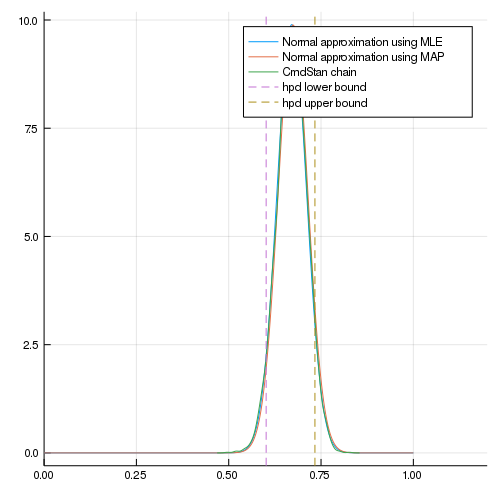

In [18]:
plot( x, pdf.(Normal( mu_avg , sigma_avg  ) , x ),
xlim=(0.0, 1.2), lab="Normal approximation using MLE")
plot!( x, pdf.(Normal( Optim.minimizer(res)[1] , std(draws, mean=mean(chn.value))) , x),
lab="Normal approximation using MAP")
density!(draws, lab="CmdStan chain")
vline!([bnds[1]], line=:dash, lab="hpd lower bound")
vline!([bnds[2]], line=:dash, lab="hpd upper bound")

End of `02/clip_08s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*